In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
from scipy.stats import binom

In [3]:
df = pd.read_csv('./data/train.csv')
df.head()
print(df.shape)

(3960, 82)


In [4]:
df['PAQ-PAQ_Total'] = df['PAQ_A-PAQ_A_Total'].combine_first(df['PAQ_C-PAQ_C_Total'])
df = df.drop(['PAQ_A-PAQ_A_Total','PAQ_C-PAQ_C_Total'],axis=1)
df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

Merging PAQ children and adolescents columns

In [5]:
idx = df.columns.get_loc('PAQ_A-Season')
df.insert(idx, 'PAQ-PAQ_Total', df.pop('PAQ-PAQ_Total'))
df.columns

Index(['id', 'Basic_Demos-Enroll_Season', 'Basic_Demos-Age', 'Basic_Demos-Sex',
       'CGAS-Season', 'CGAS-CGAS_Score', 'Physical-Season', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Season', 'Fitness_Endurance-Max_Stage',
       'Fitness_Endurance-Time_Mins', 'Fitness_Endurance-Time_Sec',
       'FGC-Season', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone', 'FGC-FGC_GSND',
       'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone', 'FGC-FGC_PU',
       'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone', 'FGC-FGC_SRR',
       'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone', 'BIA-Season',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST'

Removing all columns that contain season except internet usage

In [6]:
col_to_be_kept = 'PreInt_EduHx-Season'
col_names = []
for col in df.columns:
    if 'Season' in col and col != col_to_be_kept:
        col_names.append(col)
print(col_names)
df = df.drop(columns=col_names)
df.columns

['Basic_Demos-Enroll_Season', 'CGAS-Season', 'Physical-Season', 'Fitness_Endurance-Season', 'FGC-Season', 'BIA-Season', 'PAQ_A-Season', 'PAQ_C-Season', 'PCIAT-Season', 'SDS-Season']


Index(['id', 'Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score',
       'Physical-BMI', 'Physical-Height', 'Physical-Weight',
       'Physical-Waist_Circumference', 'Physical-Diastolic_BP',
       'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ-PAQ_Total', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02',
       'PCIAT-PCIAT_03', 'PCIAT-PC

Removing rows that don't have atleast 50% of features available

In [7]:
threshold = df.shape[1]/2
df = df.dropna(thresh=threshold)
df.shape


(2641, 71)

Separating categorical and numerical columns 

In [8]:
categorical_cols = df.select_dtypes(include=["category", "object"]).columns  
numeric_cols = df.select_dtypes(include=["number"]).columns 

#Converting categorical into numericla data
label_encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = label_encoder.fit_transform(df[col])
print(categorical_cols)
print(numeric_cols)

Index(['id', 'PreInt_EduHx-Season'], dtype='object')
Index(['Basic_Demos-Age', 'Basic_Demos-Sex', 'CGAS-CGAS_Score', 'Physical-BMI',
       'Physical-Height', 'Physical-Weight', 'Physical-Waist_Circumference',
       'Physical-Diastolic_BP', 'Physical-HeartRate', 'Physical-Systolic_BP',
       'Fitness_Endurance-Max_Stage', 'Fitness_Endurance-Time_Mins',
       'Fitness_Endurance-Time_Sec', 'FGC-FGC_CU', 'FGC-FGC_CU_Zone',
       'FGC-FGC_GSND', 'FGC-FGC_GSND_Zone', 'FGC-FGC_GSD', 'FGC-FGC_GSD_Zone',
       'FGC-FGC_PU', 'FGC-FGC_PU_Zone', 'FGC-FGC_SRL', 'FGC-FGC_SRL_Zone',
       'FGC-FGC_SRR', 'FGC-FGC_SRR_Zone', 'FGC-FGC_TL', 'FGC-FGC_TL_Zone',
       'BIA-BIA_Activity_Level_num', 'BIA-BIA_BMC', 'BIA-BIA_BMI',
       'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM',
       'BIA-BIA_FFMI', 'BIA-BIA_FMI', 'BIA-BIA_Fat', 'BIA-BIA_Frame_num',
       'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM',
       'BIA-BIA_TBW', 'PAQ-PAQ_Total', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT

Imputing missing values with KNNImputer

In [9]:
imputer = KNNImputer(n_neighbors=7)
imputed_data = imputer.fit_transform(df)
train_imputed = pd.DataFrame(imputed_data, columns=df.columns) 
train_imputed.head()
if 'sii' in train_imputed.columns:  
   train_imputed['sii'] = train_imputed['sii'].round().astype(int)  
df = train_imputed
df.head()

,id,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,...,PCIAT-PCIAT_17,PCIAT-PCIAT_18,PCIAT-PCIAT_19,PCIAT-PCIAT_20,PCIAT-PCIAT_Total,SDS-SDS_Total_Raw,SDS-SDS_Total_T,PreInt_EduHx-Season,PreInt_EduHx-computerinternet_hoursday,sii
0,0.0,5.0,0.0,51.000000,16.877316,46.0,50.8,26.000000,68.0,85.571429,...,4.0,4.0,2.0,4.0,55.0,39.142857,55.428571,0.0,3.0,2
1,1.0,9.0,0.0,64.714286,14.035590,48.0,46.0,22.000000,75.0,70.000000,...,0.0,0.0,0.0,0.0,0.0,46.000000,64.000000,2.0,0.0,0
2,2.0,10.0,1.0,71.000000,16.648696,56.5,75.6,25.428571,65.0,94.000000,...,2.0,2.0,1.0,1.0,28.0,38.000000,54.000000,2.0,2.0,0
3,3.0,9.0,0.0,71.000000,18.292347,56.0,81.6,29.428571,60.0,97.000000,...,4.0,3.0,4.0,1.0,44.0,31.000000,45.000000,3.0,0.0,1
4,4.0,13.0,1.0,50.000000,22.279952,59.5,112.2,30.571429,60.0,73.000000,...,3.0,1.0,2.0,1.0,34.0,40.000000,56.000000,1.0,0.0,1


In [10]:
train_imputed.isnull().values.any()

False

In [11]:
#additional cleaning
df = df.drop('id', axis=1)
df.head()
print(df.shape)

(2641, 70)


In [12]:
#splitting train and test data for feature selection 
X_fs = df.drop('sii',axis=1)
y_fs = df['sii']
X = df.drop('sii',axis=1)
y = df['sii']
y_fs.head()

0    2
1    0
2    0
3    1
4    1
Name: sii, dtype: int32

In [13]:
#adding shadow features
for col in X_fs.columns:
    X_fs[f"shadow_{col}"] = X_fs[col].sample(frac=1).reset_index(drop=True)
X_fs.head()

,Basic_Demos-Age,Basic_Demos-Sex,CGAS-CGAS_Score,Physical-BMI,Physical-Height,Physical-Weight,Physical-Waist_Circumference,Physical-Diastolic_BP,Physical-HeartRate,Physical-Systolic_BP,...,shadow_PCIAT-PCIAT_16,shadow_PCIAT-PCIAT_17,shadow_PCIAT-PCIAT_18,shadow_PCIAT-PCIAT_19,shadow_PCIAT-PCIAT_20,shadow_PCIAT-PCIAT_Total,shadow_SDS-SDS_Total_Raw,shadow_SDS-SDS_Total_T,shadow_PreInt_EduHx-Season,shadow_PreInt_EduHx-computerinternet_hoursday
0,5.0,0.0,51.000000,16.877316,46.0,50.8,26.000000,68.0,85.571429,113.571429,...,0.0,1.0,3.0,0.0,0.0,34.000000,27.000000,53.000000,1.0,0.0
1,9.0,0.0,64.714286,14.035590,48.0,46.0,22.000000,75.0,70.000000,122.000000,...,0.0,2.0,3.0,4.0,0.0,3.000000,30.000000,51.000000,0.0,1.0
2,10.0,1.0,71.000000,16.648696,56.5,75.6,25.428571,65.0,94.000000,117.000000,...,2.0,4.0,2.0,0.0,0.0,58.000000,46.000000,51.857143,3.0,1.0
3,9.0,0.0,71.000000,18.292347,56.0,81.6,29.428571,60.0,97.000000,117.000000,...,2.0,1.0,3.0,0.0,2.0,42.000000,37.000000,45.000000,0.0,2.0
4,13.0,1.0,50.000000,22.279952,59.5,112.2,30.571429,60.0,73.000000,102.000000,...,4.0,0.0,1.0,1.0,0.0,23.714286,41.285714,66.000000,0.0,2.0


In [14]:
def boruta_feature_selection(X,y):
    rf = RandomForestClassifier(max_depth=20)
    rf.fit(X,y)
    #Creating a dictionary with the features and their respective importances
    feature_importances = {f_name:f_imp for f_name,f_imp in zip(X.columns,rf.feature_importances_)}
    #Filtering out the shadow features
    shadow_feature_importances = {key:value for key,value in feature_importances.items() if "shadow" in key}
    #Finding the shadow feature that has the highest importance
    highest_shadow_feature = max(shadow_feature_importances.values())
    #Filtering out the features that have importance higher than the highest shadow feature
    selected_features = {key for key,value in feature_importances.items() if value > highest_shadow_feature}
    return selected_features

In [15]:
trials = 50
feature_hits = {i:0 for i in X.columns}
for _ in tqdm(range(trials)):
    imp_features = boruta_feature_selection(X_fs,y_fs)
    for feature in imp_features:
        feature_hits[feature] += 1
print(feature_hits)

  0%|          | 0/50 [00:00<?, ?it/s]

{'Basic_Demos-Age': 40, 'Basic_Demos-Sex': 0, 'CGAS-CGAS_Score': 0, 'Physical-BMI': 8, 'Physical-Height': 48, 'Physical-Weight': 46, 'Physical-Waist_Circumference': 13, 'Physical-Diastolic_BP': 0, 'Physical-HeartRate': 0, 'Physical-Systolic_BP': 0, 'Fitness_Endurance-Max_Stage': 0, 'Fitness_Endurance-Time_Mins': 0, 'Fitness_Endurance-Time_Sec': 3, 'FGC-FGC_CU': 6, 'FGC-FGC_CU_Zone': 0, 'FGC-FGC_GSND': 17, 'FGC-FGC_GSND_Zone': 0, 'FGC-FGC_GSD': 18, 'FGC-FGC_GSD_Zone': 0, 'FGC-FGC_PU': 0, 'FGC-FGC_PU_Zone': 0, 'FGC-FGC_SRL': 0, 'FGC-FGC_SRL_Zone': 0, 'FGC-FGC_SRR': 0, 'FGC-FGC_SRR_Zone': 0, 'FGC-FGC_TL': 0, 'FGC-FGC_TL_Zone': 0, 'BIA-BIA_Activity_Level_num': 0, 'BIA-BIA_BMC': 0, 'BIA-BIA_BMI': 10, 'BIA-BIA_BMR': 48, 'BIA-BIA_DEE': 43, 'BIA-BIA_ECW': 30, 'BIA-BIA_FFM': 48, 'BIA-BIA_FFMI': 6, 'BIA-BIA_FMI': 5, 'BIA-BIA_Fat': 17, 'BIA-BIA_Frame_num': 0, 'BIA-BIA_ICW': 38, 'BIA-BIA_LDM': 48, 'BIA-BIA_LST': 50, 'BIA-BIA_SMM': 47, 'BIA-BIA_TBW': 35, 'PAQ-PAQ_Total': 12, 'PCIAT-PCIAT_01': 50, '

In [16]:
#Calculating the probability mass function of x
pmf = [binom.pmf(x,trials,0.5) for x in range(trials+1)]
print(pmf)

[8.881784197001254e-16, 4.4408920985006104e-14, 1.0880185641326552e-12, 1.7408297026122506e-11, 2.0454749005693838e-10, 1.881836908523833e-09, 1.4113776813928742e-08, 8.871516854469495e-08, 4.768440309277371e-07, 2.2252721443294427e-06, 9.123615791750716e-06, 3.317678469727518e-05, 0.00010782455026614453, 0.00031517945462411566, 0.0008329742729351613, 0.001999138255044388, 0.004373114932909585, 0.008746229865819174, 0.016034754754001845, 0.027005902743582028, 0.04185914925255215, 0.059798784646503254, 0.0788256706703904, 0.09596168603351869, 0.10795689678770863, 0.11227517265921712, 0.10795689678770864, 0.09596168603351869, 0.07882567067039037, 0.05979878464650316, 0.04185914925255215, 0.027005902743582055, 0.016034754754001842, 0.008746229865819176, 0.004373114932909585, 0.0019991382550443885, 0.0008329742729351612, 0.00031517945462411566, 0.00010782455026614453, 3.317678469727517e-05, 9.123615791750718e-06, 2.225272144329443e-06, 4.768440309277371e-07, 8.871516854469495e-08, 1.411377

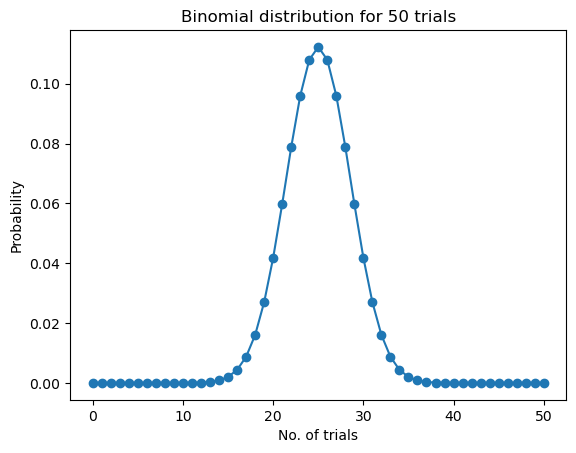

In [17]:
#plotting the binomial distribution
plt.plot([i for i in range(trials+1)],pmf,"-o")
plt.title(f"Binomial distribution for {trials} trials")
plt.xlabel("No. of trials")
plt.ylabel("Probability")
plt.show()

In [18]:
#Finding the threshold for the left tail of binomial distribution
def get_left_tail(pmf):
    for i,x in enumerate(pmf):
        total = 0
        total += x
        if total >=0.05:
            break
    return i

print(get_left_tail(pmf))

21


In [19]:
#Choosing the features that have have appeared greater than the selected threshold
def choose_features(feature_hits,thresh):
    imp_features = [key for key,value in feature_hits.items() if value >= thresh]
    return imp_features


In [20]:
thresh = get_left_tail(pmf)
imp_features = choose_features(feature_hits,thresh)
print(imp_features)

['Basic_Demos-Age', 'Physical-Height', 'Physical-Weight', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW', 'PCIAT-PCIAT_01', 'PCIAT-PCIAT_02', 'PCIAT-PCIAT_03', 'PCIAT-PCIAT_04', 'PCIAT-PCIAT_05', 'PCIAT-PCIAT_06', 'PCIAT-PCIAT_07', 'PCIAT-PCIAT_08', 'PCIAT-PCIAT_09', 'PCIAT-PCIAT_10', 'PCIAT-PCIAT_11', 'PCIAT-PCIAT_12', 'PCIAT-PCIAT_13', 'PCIAT-PCIAT_14', 'PCIAT-PCIAT_15', 'PCIAT-PCIAT_16', 'PCIAT-PCIAT_17', 'PCIAT-PCIAT_18', 'PCIAT-PCIAT_19', 'PCIAT-PCIAT_20', 'PCIAT-PCIAT_Total']


In [22]:
final_train= X[imp_features]
print(final_train)

      Basic_Demos-Age  Physical-Height  Physical-Weight  BIA-BIA_BMR  \
0                 5.0             46.0             50.8   932.498000   
1                 9.0             48.0             46.0   936.656000   
2                10.0             56.5             75.6  1070.003857   
3                 9.0             56.0             81.6  1131.430000   
4                13.0             59.5            112.2  1330.970000   
...               ...              ...              ...          ...   
2636              8.0             52.5             67.2  1035.270000   
2637              7.0             48.5             46.6   966.287000   
2638             13.0             59.5             82.4  1206.880000   
2639             11.0             60.0            109.8  1253.740000   
2640             13.0             70.7             87.0  1414.340000   

      BIA-BIA_DEE  BIA-BIA_ECW  BIA-BIA_FFM  BIA-BIA_ICW  BIA-BIA_LDM  \
0     1492.000000     8.255980    41.586200    24.434900     8

In [30]:
y.value_counts()

sii
0    1515
1     743
2     350
3      33
Name: count, dtype: int64

In [24]:
from sklearn.preprocessing import StandardScaler

columns_to_scale = ['Physical-Height', 'Physical-Weight', 'BIA-BIA_BMR', 'BIA-BIA_DEE', 'BIA-BIA_ECW', 'BIA-BIA_FFM', 'BIA-BIA_ICW', 'BIA-BIA_LDM', 'BIA-BIA_LST', 'BIA-BIA_SMM', 'BIA-BIA_TBW','PCIAT-PCIAT_Total']  # Adjust this list as needed

df_to_scale = final_train[columns_to_scale]
df_other = final_train.drop(columns=columns_to_scale)
scaler = StandardScaler()
df_scaled_values = scaler.fit_transform(df_to_scale)
df_scaled_columns = pd.DataFrame(df_scaled_values, columns=columns_to_scale, index=df.index)
df_final = pd.concat([df_other, df_scaled_columns], axis=1)

df_final.head()

,Basic_Demos-Age,PCIAT-PCIAT_01,PCIAT-PCIAT_02,PCIAT-PCIAT_03,PCIAT-PCIAT_04,PCIAT-PCIAT_05,PCIAT-PCIAT_06,PCIAT-PCIAT_07,PCIAT-PCIAT_08,PCIAT-PCIAT_09,...,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-PCIAT_Total
0,5.0,5.0,4.0,4.0,0.0,4.0,0.0,0.0,4.0,0.0,...,-0.178219,-0.222761,-0.188336,-0.178219,-0.168954,-0.174263,-0.286781,-0.192706,-0.180160,1.352734
1,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.175691,-0.220093,-0.223083,-0.175691,-0.237679,-0.075631,-0.281226,-0.248577,-0.229741,-1.389671
2,10.0,5.0,2.0,2.0,1.0,2.0,1.0,1.0,2.0,1.0,...,-0.094605,-0.139724,-0.082050,-0.094604,-0.115975,-0.090120,-0.146249,-0.140484,-0.096927,0.006462
3,9.0,4.0,2.0,4.0,0.0,5.0,1.0,0.0,3.0,2.0,...,-0.057253,-0.049657,-0.074332,-0.057250,-0.048288,-0.046344,-0.077789,-0.098856,-0.063099,0.804253
4,13.0,3.0,3.0,3.0,0.0,2.0,1.0,0.0,2.0,2.0,...,0.064082,-0.020363,0.152851,0.064080,0.002452,0.020556,0.139017,0.021534,0.087606,0.305634


In [31]:
df_scaled_columns

,Physical-Height,Physical-Weight,BIA-BIA_BMR,BIA-BIA_DEE,BIA-BIA_ECW,BIA-BIA_FFM,BIA-BIA_ICW,BIA-BIA_LDM,BIA-BIA_LST,BIA-BIA_SMM,BIA-BIA_TBW,PCIAT-PCIAT_Total
0,-1.341675,-0.920543,-0.178219,-0.222761,-0.188336,-0.178219,-0.168954,-0.174263,-0.286781,-0.192706,-0.180160,1.352734
1,-1.071490,-1.033532,-0.175691,-0.220093,-0.223083,-0.175691,-0.237679,-0.075631,-0.281226,-0.248577,-0.229741,-1.389671
2,0.076798,-0.336763,-0.094605,-0.139724,-0.082050,-0.094604,-0.115975,-0.090120,-0.146249,-0.140484,-0.096927,0.006462
3,0.009251,-0.195526,-0.057253,-0.049657,-0.074332,-0.057250,-0.048288,-0.046344,-0.077789,-0.098856,-0.063099,0.804253
4,0.482076,0.524782,0.064082,-0.020363,0.152851,0.064080,0.002452,0.020556,0.139017,0.021534,0.087606,0.305634
...,...,...,...,...,...,...,...,...,...,...,...,...
2636,-0.463573,-0.534495,-0.115726,-0.115249,-0.145598,-0.115724,-0.143142,-0.061985,-0.178063,-0.182924,-0.144729,-0.292709
2637,-1.003943,-1.019409,-0.157673,-0.317381,-0.161421,-0.157672,-0.257449,-0.072938,-0.246052,-0.212287,-0.203435,0.255772
2638,0.482076,-0.176695,-0.011374,0.001804,-0.014216,-0.011373,0.011686,-0.026861,-0.000993,-0.054231,-0.002963,0.205910
2639,0.549622,0.468287,0.017120,-0.016536,0.001655,0.017123,0.024009,0.027668,0.052272,-0.067754,0.011386,0.156048


Class Imbalancing - oversampling

In [44]:
from collections import Counter
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

import numpy as np
from sklearn.datasets import make_classification

X= df_final
X, y = make_classification(
    n_classes=4, class_sep=2, weights=[0.6, 0.3, 0.09, 0.01],
    n_informative=5, n_redundant=0, flip_y=0, n_features=10, n_clusters_per_class=1, random_state=42
)

print("Original class distribution:", Counter(y))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_smote))

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (d:\anaconda application\anaconda\Lib\site-packages\sklearn\utils\_param_validation.py)